### Финальный проект: задачи по исследованию мобильного приложения. Вариант №1.

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import scipy.stats as ss
from scipy.stats import normaltest
from scipy.stats import chi2_contingency
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

_______________________________________________________________________________________________________________________________

#### Оглавление

- [Задание № 1. Функция Retention](#Задание-1)
- [Задание № 2. AB-test](#Задание-2)
- [Задание № 3. Рекомендации по метрикам](#Задание-3)


_______________________________________________________________________________________________________________________________

#### Для начала подгрузим данные из трёх имеющихся таблиц и посмотрим на то, как их интерпретировать:

- Файл **problem1-reg_data.csv** - содержит в себе данные о времени регистрации пользователей. 

In [2]:
reg_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-kuksova/shared/problem1-reg_data.csv', sep=';')
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s') # меняем формат даты
reg_data.head()

,reg_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,2000-01-13 22:27:27,3
3,2000-05-28 14:19:01,4
4,2000-09-16 11:21:53,5


**reg_ts** — данные о времени регистрации пользователей.

**uid** — идентификационный номер пользователя.

In [3]:
print(f'''Размер датафрейма:
{reg_data.shape}
Типы данных:
{reg_data.dtypes}
Отсутствуют ли значения:
{reg_data.isna().value_counts()}''')
# смотрим размерность датафрейма, знакомимся с типами данных,проверяем, где отсутствуют значения / NaN - отсутствуют

Размер датафрейма:
(1000000, 2)
Типы данных:
reg_ts    datetime64[ns]
uid                int64
dtype: object
Отсутствуют ли значения:
reg_ts  uid  
False   False    1000000
dtype: int64


_______________________________________________________________________________________________________________________________

- Файл **problem1-auth_data.csv.csv** — содержит данные о времени входа пользователей в игру.

In [4]:
auth_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-kuksova/shared/problem1-auth_data.csv', sep=';')
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s') # меняем формат даты
auth_data.head() 

,auth_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,1999-07-25 16:46:46,2
3,1999-07-31 03:50:15,2
4,1999-08-05 17:49:39,2


**auth_ts** — данные о времени входа пользователей в игру.

**uid** — идентификационный номер пользователя.

In [5]:
print(f'''Размер датафрейма:
{auth_data.shape}
Типы данных:
{auth_data.dtypes}
Отсутствуют ли значения:
{auth_data.isna().value_counts()}''')
# смотрим размерность датафрейма, знакомимся с типами данных,проверяем, где отсутствуют значения / NaN - отсутствуют

Размер датафрейма:
(9601013, 2)
Типы данных:
auth_ts    datetime64[ns]
uid                 int64
dtype: object
Отсутствуют ли значения:
auth_ts  uid  
False    False    9601013
dtype: int64


_______________________________________________________________________________________________________________________________

- Файл **ab_test_data.csv** - содержит в себе данные результата A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений.

In [6]:
ab_test_data = pd.read_csv('ab_test_data.csv', sep=';')
ab_test_data.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


**user_id** — идентификационный номер пользователя.

**revenue** — выручка, полученная от пользователя с определенным id.

**testgroup** — принадлежность пользователя к контрольной или тестовой группе (a/b)

In [7]:
print(f'''Размер датафрейма:
{ab_test_data.shape}
Типы данных:
{ab_test_data.dtypes}
Отсутствуют ли значения:
{ab_test_data.isna().value_counts()}''')
# смотрим размерность датафрейма, знакомимся с типами данных,проверяем, где отсутствуют значения / NaN - отсутствуют

Размер датафрейма:
(404770, 3)
Типы данных:
user_id       int64
revenue       int64
testgroup    object
dtype: object
Отсутствуют ли значения:
user_id  revenue  testgroup
False    False    False        404770
dtype: int64


Данные проверены, проинтерпретированы.

По результатам рассмотрения данных отмечаю, что в каждой из таблиц находятся одинаковые колонки, которые привязывают конкретное действие (регистрация/входы/доход/группа) к пользователю. Также замечаем, что в таблице с аутенфикацией пользователей строк гораздо больше, чем в дф с данными о регистрации, что логично. Пользователи регистрируются один раз, а входят в игру некоторое количество раз.

Так как мы работаем с временными промежутками и иных данных кроме id нет, было бы здорово посмотреть отправную и завершающую дату в датафреймах reg_data и auth_data, чтобы понимать, какой рассматриваем период.

In [8]:
reg_min = reg_data.reg_ts.min() # узнаем дату начала для дф reg_data
print(f'Первая зафиксированная дата/время регистрации: {reg_min}')
auth_min = auth_data.auth_ts.min() # узнаем дату начала для дф auth_data
print(f'Первая зафиксированная дата/время входа: {reg_min}')

Первая зафиксированная дата/время регистрации: 1998-11-18 09:43:43
Первая зафиксированная дата/время входа: 1998-11-18 09:43:43


In [9]:
reg_max = reg_data.reg_ts.max()
print(f'Последняя зафиксированная дата/время регистрации: {reg_max}')
auth_max = auth_data.auth_ts.max()
print(f'Последняя зафиксированная дата/время входа: {reg_max}')

Последняя зафиксированная дата/время регистрации: 2020-09-23 15:17:24
Последняя зафиксированная дата/время входа: 2020-09-23 15:17:24


Даты совпадают в обоих дф, имеющийся промежуток в данных - более 21 года.

Считаю обработку и интерпретацию данных завершенной, перехожу к заданиям.

_______________________________________________________________________________________________________________________________

### Задание 1
**Retention** – один из самых важных показателей в компании. Задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

Данные предоставлены за довольно большой промежуток времени, поэтому считаю, что стоит рассматривать показатель Retention по более свежим и актуальным данным.
В задании указано, что в ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

Для рассмотрения возьмем опитмальный временной промежуток - пять последних лет (с 2015 по конечную дату - 2020 год). Отфильтруем датафреймы и напишем функцию расчета:

In [10]:
reg_5y = reg_data.query('reg_ts >= "2015-01-01"')
auth_5y = auth_data.query('auth_ts >= "2015-01-01"') 

In [11]:
def retention_func(reg_data, auth_data):
    '''
    Данная функция возвращает обработанный датафрейм с расчетом retention rate, под названием ret_rate для двух наборов данных:
    - в качестве первого аругмента функция принимает датафрейм с датой регистрации пользователей и uid пользователя.
    - в качестве второго аругмента функция принимает датафрейм с датами авторизации пользователей и uid пользователя.
    '''
    reg_auth = auth_data.merge(reg_data, on = 'uid') # объединим датафреймы с датой регистрации и датой входа по uid
    reg_auth['days_after_reg'] = (reg_auth['auth_ts'] - reg_auth['reg_ts']).dt.days # посчитаем кол-во дней прошедших от рег до входа
    ret_rate = reg_auth.groupby('days_after_reg')\
                        .agg({'uid': 'nunique'})\
                        .reset_index()\
                        .rename(columns = {'uid': 'users_count'}) #группируем по дням и агрегируем для уникальных пользователей 
    ret_rate['retention_rate'] = (ret_rate.users_count / reg_auth.uid.nunique() * 100).round(2) # находим retention в %
    ret_rate = ret_rate.drop(labels = [0],axis = 0) # убираем первый день, где retention 100%
    return ret_rate # возвращаем retention rate

Проверяем документацию для функции:

In [12]:
help(retention_func)

Help on function retention_func in module __main__:

retention_func(reg_data, auth_data)
    Данная функция возвращает обработанный датафрейм с расчетом retention rate, под названием ret_rate для двух наборов данных:
    - в качестве первого аругмента функция принимает датафрейм с датой регистрации пользователей и uid пользователя.
    - в качестве второго аругмента функция принимает датафрейм с датами авторизации пользователей и uid пользователя.



Проверяем работу функции на наборе данных за 5 последних лет:

In [13]:
retention_rate5y = retention_func(reg_5y, auth_5y)

In [14]:
retention_rate5y.head()

,days_after_reg,users_count,retention_rate
1,1,38878,4.02
2,2,41622,4.30
3,3,47581,4.92
4,4,54275,5.61
5,5,61621,6.37


_______________________________________________________________________________________________________________________________

В задании нас не просят о том, чтобы проанализировать полученные данные, но я вернулась обратно к функции и добавила в нее в возможность построения графика retention, потому что для данного показателя это было бы очень удобно :)

In [53]:
def retention_func_with_plot(reg_data, auth_data):
    '''
    Данная функция возвращает обработанный датафрейм с расчетом retention rate, под названием ret_rate для двух наборов данных:
    - в качестве первого аругмента функция принимает датафрейм с датой регистрации пользователей и uid пользователя.
    - в качестве второго аругмента функция принимает датафрейм с датами авторизации пользователей и uid пользователя.
    Также, в результате исполнения отрисовывает лайнплот retention rate.
    *Для просмотра финального датафрейма требуется вызвать переменную, в которую записывается датафрейм. 
    '''
    reg_auth = auth_data.merge(reg_data, on = 'uid') # объединим датафреймы по колонке с датой регистрации и датой входа
    reg_auth['days_after_reg'] = (reg_auth['auth_ts'] - reg_auth['reg_ts']).dt.days # посчитаем кол-во дней прошедших от рег до входа
    ret_rate = reg_auth.groupby('days_after_reg')\
                        .agg({'uid': 'nunique'})\
                        .rename(columns = {'uid': 'users_count'})\
                        .reset_index() #группируем по дням и агрегируем для уникальных пользователей 
    ret_rate['retention_rate'] = (ret_rate.users_count / reg_auth.uid.nunique() * 100).round(2) # находим retention в %
    ret_rate = ret_rate.drop(labels = [0],axis = 0) # убираем первый день, где retention 100%
    
    plt.figure(figsize=(15, 7)) # построение графика универсального для любого набора данных
    sns.set_style("whitegrid")
    retention_plot = sns.lineplot(x='days_after_reg', y='retention_rate', data=ret_rate.query('days_after_reg <= 60')) # ret_rate можно отфильтровать для вывода retention по любому количеству дней
    plt.title('Удержание пользователя (в днях)')
    plt.xlabel('Количество дней с момента регистрации')
    plt.ylabel('% удержания пользователей')
    return ret_rate, retention_plot # возвращаем retention rate, возвращаем retention plot

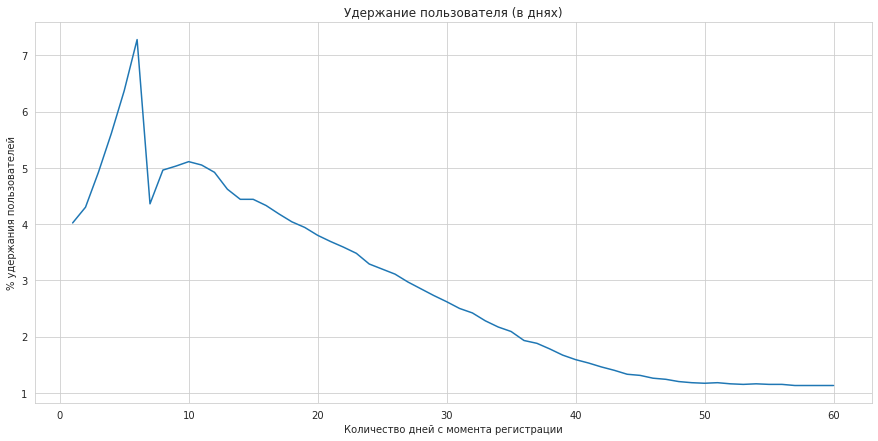

In [54]:
retention_rate, retention_plot = retention_func_with_plot(reg_5y, auth_5y)

По графику, можем сразу увидеть, что с 50 дня процент авторизующихся игроков резко уменьшается, и данная тенденция не меняется. Для подтверждения можем поменять в функции вывод графика за период 90-120 дней и увидим, что ничего не изменится. Просадка присутствует примерно на 7 день, далее немного возрастает и после десятого дня идет тенденция на снижение процента авторизовавшихся игроков.

In [17]:
retention_rate.head() # вывод итогового датафрейма с расчитанным retention

,days_after_reg,users_count,retention_rate
1,1.0,38878,4.01
2,2.0,41622,4.29
3,3.0,47581,4.91
4,4.0,54275,5.60
5,5.0,61621,6.35


Как вариант, функцию можно разбить на отдельные функции: для df и для графика.

_______________________________________________________________________________________________________________________________

### Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

#### Этап 1. Анализ исходных данных

- Таблицу для исследования мы подготовили выше, проверили размерность, проверили на отсутствующие значения и посмотрели на типы данных.
Начать можно с фильтрования по группам исходного датафрейма:

In [18]:
group_a = ab_test_data.query('testgroup == "a"')
group_a.head()

,user_id,revenue,testgroup
1,2,0,a
2,3,0,a
9,10,0,a
10,11,0,a
11,12,0,a


In [19]:
group_b = ab_test_data.query('testgroup == "b"')
group_b.head()

,user_id,revenue,testgroup
0,1,0,b
3,4,0,b
4,5,0,b
5,6,0,b
6,7,0,b


- Также, проверяем, сколько уникальных пользователей присутствует по группам, совпадает ли число с условием задачи и какая группая является контрольной, а какая тестовой:

In [20]:
print(f'Контрольная группа: {group_a.user_id.nunique()}') # совпадение - контрольная группа
print(f'Тестовая группа: {group_b.user_id.nunique()}') # совпадение - тестовая группа

Контрольная группа: 202103
Тестовая группа: 202667


- Следующим действием посмотрим, присутствуют ли выбросы по выручке у групп:

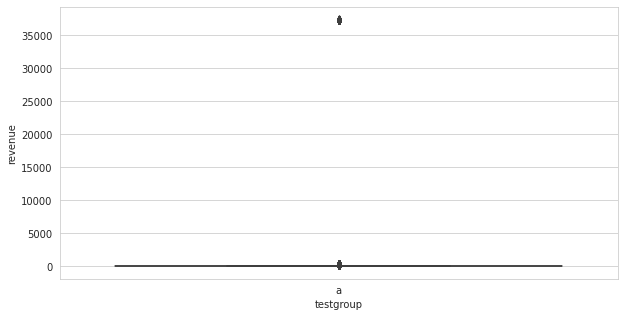

In [21]:
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
sns.boxplot(x = 'testgroup', y = 'revenue', data = group_a) # контрольная группа

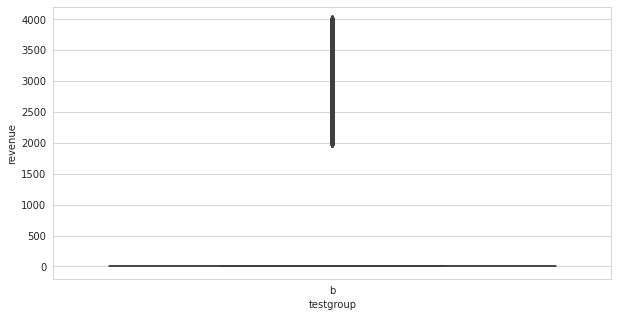

In [22]:
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
sns.boxplot(x = 'testgroup', y = 'revenue', data = group_b) # тестовая группа

**По результатам рассмотрения, в контрольной группе присутствуют выбросы.**

- Далее, стоит посмотреть на описательные характеристики по прибыли обеих групп:

In [23]:
group_a.revenue.describe()

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [24]:
group_b.revenue.describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

**По результатам рассмотрения, в контрольной и тестовой группах различается размер максимальной покупки.**

- Исходя из предыдущего вывода, стоит проверить количество платящих пользователей и посмотреть на распределение размерности платежей:

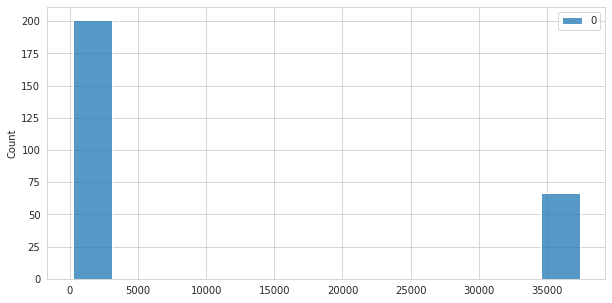

In [25]:
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
sns.histplot(group_a.query('revenue != 0').groupby('revenue')) # контрольная группа

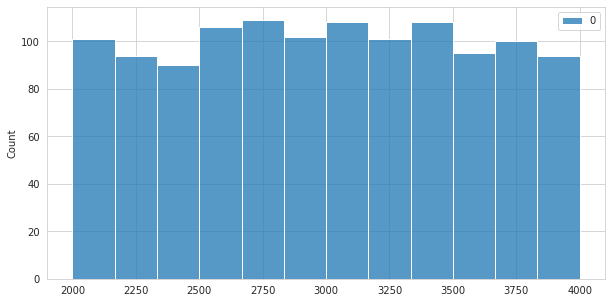

In [26]:
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
sns.histplot(group_b.query('revenue != 0').groupby('revenue')) # тестовая группа

**По результатам видим, что в тестовой группе платежи распределяеются от 2000 до 4000, в контрольной присутствует в целом две группы пользователей - одна с большими платежами, а вторая близка к тестовой группе.**


- На следующем шаге рассмотрим общее значение прибыли у обеих групп:

In [27]:
print(f'Контрольная группа: {group_a.revenue.sum()}') # контрольная группа
print(f'Тестовая группа: {group_b.revenue.sum()}') #тестовая группа
print(f'Разница контроль/тест: {group_b.revenue.sum() - group_a.revenue.sum()}') # разница
print(f'В тестовой группе прибыль больше на {(group_b.revenue.sum() / group_a.revenue.sum() * 100 - 100).round(2)}%') # разница

Контрольная группа: 5136189
Тестовая группа: 5421603
Разница контроль/тест: 285414
В тестовой группе прибыль больше на 5.56%


_______________________________________________________________________________________________________________________________

#### Этап 2. Выбор метрик для исследования и их подсчёт

Выбор метрик, в первую очередь обсуславливается тем, какие данные у нас имеются изначально - пользователи и выручка. Наиболее подходящими метриками для анализа в текущей ситуации считаю:

- Cредний доход от пользователя (ARPU) - заодно проверим различие в 5%, которое дано в условии.
- Средний доход от платящего пользователя (ARPPU).
- Отношение двух показателей друг к другу (в данном случае: доля платящих пользователей ко всем пользователям) - конверсия (CR).

**Считаем ARPU в обеих группах:**

In [28]:
ARPU_for_a = group_a.revenue.mean().round(3)
print(f'ARPU в контрольной группе: {ARPU_for_a}')

ARPU в контрольной группе: 25.414


In [29]:
ARPU_for_b = group_b.revenue.mean().round(3)
print(f'ARPU в тестовой группе: {ARPU_for_b}')

ARPU в тестовой группе: 26.751


In [30]:
print(f'Различия ARPU в группах в процентном соотношении: в тестовой группе больше на {((ARPU_for_b / ARPU_for_a * 100) - 100).round(2)}%')

Различия ARPU в группах в процентном соотношении: в тестовой группе больше на 5.26%


**Считаем ARPPU в обеих группах:**

In [31]:
ARPPU_for_a = (group_a.query('revenue > 0').revenue.sum() / group_a.query('revenue > 0').user_id.nunique()).round(3)
print(f'ARPPU в контрольной группе: {ARPPU_for_a}')

ARPPU в контрольной группе: 2663.998


In [32]:
ARPPU_for_b = (group_b.query('revenue > 0').revenue.sum() / group_b.query('revenue > 0').user_id.nunique()).round(3)
print(f'ARPPU в тестовой группе: {ARPPU_for_b}')

ARPPU в тестовой группе: 3003.658


In [33]:
print(f'Различия ARPPU в группах в процентном соотношении: в тестовой группе больше на {((ARPPU_for_b / ARPPU_for_a * 100) - 100)}%')

Различия ARPPU в группах в процентном соотношении: в тестовой группе больше на 12.75000957207925%


**Считаем CR в обеих группах:**

In [34]:
CR_for_a = round(group_a.query('revenue > 0').user_id.nunique() / group_a.user_id.nunique(), 6)
print(f'CR в контрольной группе: {CR_for_a}')

CR в контрольной группе: 0.00954


In [35]:
CR_for_b = round(group_b.query('revenue > 0').user_id.nunique() / group_b.user_id.nunique(), 6)
print(f'CR в тестовой группе: {CR_for_b}')

CR в тестовой группе: 0.008906


In [36]:
print(f'Различия в группах: CR в контрольной группе больше на {round((CR_for_a - CR_for_b), 6)}%')

Различия в группах: CR в контрольной группе больше на 0.000634%


_______________________________________________________________________________________________________________________________

#### Этап 3. Проверка статистической значимости отличий в метриках

В первую очередь проверяем нормальность распределения выручки:

**1) Проверка контрольной группы на нормальность распределения**
- Н0: нормальное распределение.
- Н1: распределение не относится к нормальному.

In [37]:
pg.normality(group_a.revenue, method='normaltest')

,W,pval,normal
revenue,585152.731273,0.0,False


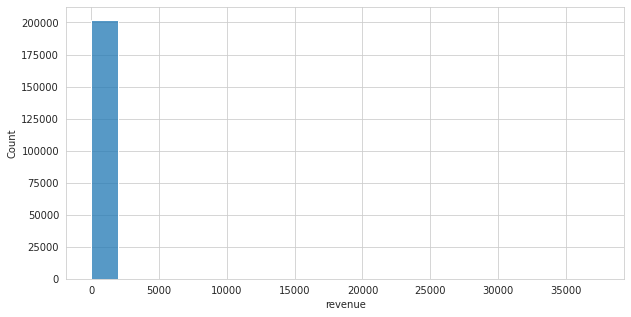

In [38]:
plt.figure(figsize=(10, 5))
sns.histplot(data = group_a, x='revenue') # визуализируем

**Тест и визуальное представление говорят о том, что распределение не является нормальным. Отвергаем нулевую гипотезу. Принимаем альтернативную.**

**2) Проверка тестовой группы на нормальность распределения**
- Н0: нормальное распределение.
- Н1: распределение не относится к нормальному.

In [39]:
pg.normality(group_b.revenue, method='normaltest')

,W,pval,normal
revenue,326622.395409,0.0,False


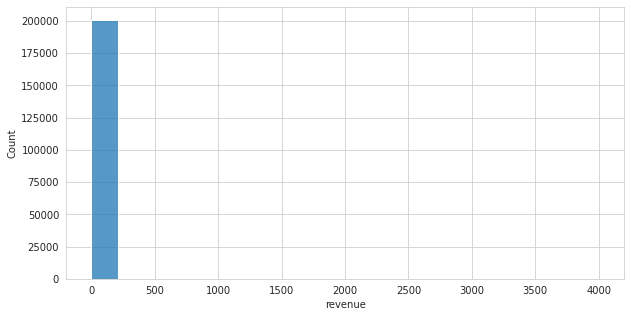

In [40]:
plt.figure(figsize=(10, 5))
sns.histplot(data = group_b, x='revenue') # визуализируем

**Тест и визуальное представление говорят о том, что распределение не является нормальным. Отвергаем нулевую гипотезу. Принимаем альтернативную.**

**3) Проверяем гомогенность дисперсий**

- Н0: дисперсии равны.
- Н1: дисперсии различны.

In [41]:
ss.levene(group_a.revenue,group_b.revenue)

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

По результатам теста можем считать дисперсии приблизительно одинаковыми (pvalue = 0.5324948591043842). Подтверждаем нулевую гипотезу.

_______________________________________________________________________________________________________________________________

**Приступаем к проверке статистической значимости отличий ARPU:**

**Выдвигаем две гипотезы:**
- H0: в контрольной и тестовой группе нет статистически значимых различий 
- H1: в контрольной и тестовой группе есть статистически значимые различия

Для статистического анализа можем использовать классический T-test Стьюдента. Распределение не является нормальным (что принимается при использовании), но дисперсии равны, что соответствует требованиям для исследования. Также можно воспользоваться Bootstrap для проверки (самовытаскивание - в эксклюзивных случаях), но в целях экономии времени, сделаем более быстрый тест.


In [42]:
print(f'Значение pvalue: {ss.ttest_ind(group_a.revenue,group_b.revenue)[1]}. Нулевая гипотеза верна (pvalue > 0.05). Говорим о том, что статистически значимых различий нет.')

Значение pvalue: 0.532494858971837. Нулевая гипотеза верна (pvalue > 0.05). Говорим о том, что статистически значимых различий нет.


_______________________________________________________________________________________________________________________________

**Приступаем к проверке статистической значимости отличий ARPPU:**

**Для начала подготовим данные и проверим распределение на нормальность и гомогенность дисперсий:**

In [43]:
a_arppu = group_a.query('revenue != 0') # выбираем только тех пользователей, которые совершили оплату
b_arppu = group_b.query('revenue != 0')

**1) Проверка контрольной группы на нормальность распределения**
- Н0: нормальное распределение.
- Н1: распределение не относится к нормальному.

In [44]:
pg.normality(a_arppu.revenue, method='normaltest')

,W,pval,normal
revenue,1394.945784,1.234161e-303,False


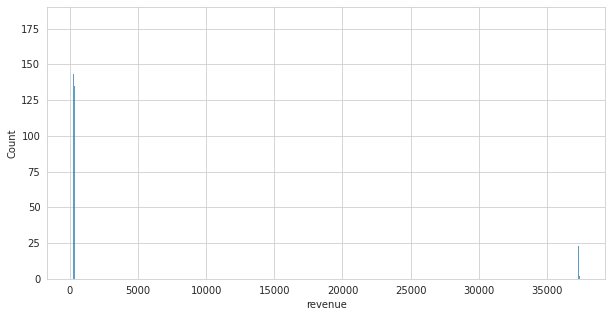

In [45]:
plt.figure(figsize=(10, 5))
sns.histplot(data = a_arppu, x='revenue') # визуализируем

**Тест и визуальное представление говорят о том, что распределение не является нормальным. Отвергаем нулевую гипотезу. Принимаем альтернативную.**

**2) Проверка тестовой группы на нормальность распределения**
- Н0: нормальное распределение.
- Н1: распределение не относится к нормальному.

In [46]:
pg.normality(b_arppu.revenue, method='normaltest')

,W,pval,normal
revenue,1068.860008,7.943249e-233,False


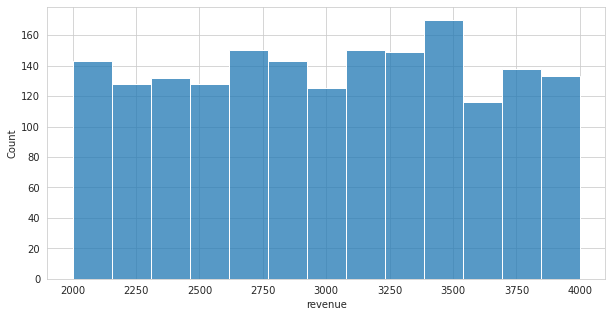

In [47]:
plt.figure(figsize=(10, 5))
sns.histplot(data = b_arppu, x='revenue') # визуализируем

**Тест и визуальное представление говорят о том, что распределение не является нормальным. Отвергаем нулевую гипотезу. Принимаем альтернативную.**

**3) Проверяем гомогенность дисперсий**

- Н0: дисперсии равны.
- Н1: дисперсии различны.

In [48]:
ss.levene(a_arppu.revenue,b_arppu.revenue)

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

По результатам теста дисперсии различаются (pvalue = 3.779689868667878e-19). Отвергаем нулевую гипотезу, принимаем альтернативную.

_______________________________________________________________________________________________________________________________

**Выдвигаем две гипотезы:**
- H0: в контрольной и тестовой группе нет статистически значимых различий 
- H1: в контрольной и тестовой группе есть статистически значимые различия

Для статистического анализа можем использовать модификацию T-test Стьюдента - T-test Уэлча. Распределение не является нормальным (что принимается при использовании), а также имеются необязательно равные известные дисперсии, что соответствует требованиям для исследования. Также можно воспользоваться Bootstrap для проверки (самовытаскивание - в эксклюзивных случаях), но в целях экономии времени, сделаем более быстрый тест.

In [49]:
print(f'Значение pvalue: {ss.ttest_ind(a_arppu.revenue, b_arppu.revenue, equal_var=False)[1]}. Нулевая гипотеза верна (pvalue > 0.05). Говорим о том, что статистически значимых различий между группами нет.')

Значение pvalue: 0.10020780398916015. Нулевая гипотеза верна (pvalue > 0.05). Говорим о том, что статистически значимых различий между группами нет.


_______________________________________________________________________________________________________________________________

**Приступаем к проверке статистической значимости отличий CR:**

**Выдвигаем две гипотезы:**
- H0: в контрольной и тестовой группе нет статистически значимых различий 
- H1: в контрольной и тестовой группе есть статистически значимые различия

Для статистического анализа будем использовать критерий хи-квадрат. Нам необходимо добавить в исходную таблицу признак того, была ли конверсия в покупку (платеж > 0): 

In [50]:
ab_test_data['convertion_to_purchase'] = ab_test_data['revenue'].apply(lambda x: 1 if x > 0 else 0) # проверяем значения выручки от пользователя, в новой колонке добавляем значение по ситуации
ab_test_data.head()

,user_id,revenue,testgroup,convertion_to_purchase
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0


In [51]:
pd.crosstab(ab_test_data.testgroup, ab_test_data.convertion_to_purchase) # проверяем таблицу сопряженности

convertion_to_purchase,0,1
testgroup,,
a,200175,1928
b,200862,1805


Делаем тест:

In [52]:
print(f'Значение pvalue: {ss.chi2_contingency(pd.crosstab(ab_test_data.testgroup, ab_test_data.convertion_to_purchase))[1]}. Отклоняем нулевую гипотезу, принимаем альтернативную (pvalue < 0.05). Говорим о том, что  есть статистически значимые различия CR.')

Значение pvalue: 0.03647561892312613. Отклоняем нулевую гипотезу, принимаем альтернативную (pvalue < 0.05). Говорим о том, что  есть статистически значимые различия CR.


_______________________________________________________________________________________________________________________________

#### Вывод:
Мы провели исследование метрик **ARPU, ARPPU и CR** в контрольной и тестовой группе. Тесты показали, что статистически значимых различий в ARPU и ARPPU не наблюдается. 
При этом, статистические различия CR в контрольной и тестовой группе являются значимыми. В тестовой группе конверсия статистически значимо ниже, чем в контрольной группе.

Далее, исходя из исследования самих данных видим, что пользователи, которые платят существенно много, находятся только в контрольной группе. В тестовой же группе платежи более устойчивые, без каких-либо скачков. Здесь можно задуматься о том, что, возможно, изначально проведенный A/B-тест наборов акционных предложений был проведен некорректно. 
Однако, по условию задачи тест всё же был проведен, поэтому **также** можно считать, что большие платежи в контрольной группе не являются аномалиями.

То есть, узнать, какую цель преследовала компания, планируя данный эксперимент и в чем суть акционных предложений, можно узнать только у самой компании. В условии задачи нет предыстории :)

На основе имеющихся данных, могу предположить два варианта развития событий:
- Если тестирование было проведено корректно - набор акционных предложений в контрольной группе смотрится привлекательнее на данный момент. Оставляем.
- Если тестирование было проведено некорректно и в контрольной группе имеются аномалии - принимаем акционные предложения тестовой группы.

_______________________________________________________________________________________________________________________________

### Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

**Метрики для оценки результатов последнего прошедшего события:**

Для наиболее успешного взаимодействия со своими пользователями необходимо опираться на самые важные метрики:
    - Retention rate - процент игроков, которые возвращаются в игру в период события. Отслеживаем, как событие
    влияет на посещаемость и насколько успешно мы удерживаем игроков.
    - DAU - количество уникальных пользователей в день. Сравниваем период прохождения события с обычным периодом.
    - МАU - количество уникальных пользователей в месяц. Сравниваем период прохождения события с обычным периодом.
    - Average Session Duration (ASD) - это среднее время сессий за период времени. Можно сравнивать с ASD в обычный период.
    - Stickiness rate (SR) - регулярность использования приложения в течение месяца. Можно сравнивать с SR в обычный период.
    - ARPU/ARPPU - в случае, если наша игра имеет донат разного рода, показатели данных метрик с введением нового события
    могут возрастать, либо наоборот уменьшаться, если предложения не заходят пользователям/являются слишком дорогими.
    - ещё было бы здорово отслеживать метрику того, насколько успешно игроки проходят события и собирают награды - доля
    пользователей от всех участников события, которые прошли событие и собрали все награды, можно адаптировать CR под данный
    случай.
    - Customer satisfaction score (CSAT) - хороший разработчик всегда будет успешно взаимодействовать со своими игроками
    если будет активно отслеживать отзывы и анализировать ответы на внутриигровые опросники. Пользователи всегда не
    против поделиться впечатлениями от события, поэтому индекс удовлетворенности игроков очень важен :)
    - Cost per acquisition (CPA) – стоимость действия. Важная метрика для отслеживания, так как новые события
    рекламируются гораздо активнее. Считается как затраты на количество приобретённых игроков.

**Метрики для оценки результатов при усложнении механики:**

Предложенное усложнение механики события может быть заведомо неудачным, по одной простой причине: это может отбить желание играть, если при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад.
Напрямую это, возможно, будет влиять на такие метрики как: DAU/MAU (в сторону снижения), ASD, Retention, ARPU/ARPPU.

Стандартный набор метрик для оценки результата не изменится, но необходимо более тщательно и даже ежедневно отслеживать текущие показатели. Также, в качестве дополнительного анализа стоит посмотреть на следующие метрики:
    - Churn rate - метрика, которая показывает, какая доля пользователей перестает заходить в игру в течение
    определенного периода времени. Можно получить представление аудитории об изменениях в игре и вовлечении игроков
    в период прохождения события.
    - Success rate per levels - самодельная метрика с поуровневой статистикой, в которой указано, какой процент
    завершенности имеет каждый из уровней игры. Выявление самого сложного для игроков уровня. Рассчитывается как доля
    игроков прошедших уровень от всех игроков, которые были на данном уровне.
    - Average count of attempts - самодельная метрика с поуровневой статистикой, в которой указывается среднее
    количество попыток для прохождения уровня. Можно связать с Success rate per levels и понять, при каком количестве
    попыток пользователям надоедает прохождение.
    - На CSAT стоит обращать повышенное внимание, так как усложнение не останется незамеченным. Стоит сразу запустить
    опросники.